Initialisation

In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

N = 10 #Number of points

Dataset generation

In [2]:
def pointgeneration():
    """
    Return a list of two numbers in [0,1]
    """
    return rd.rand(2)

In [3]:
def generateB(n):
    """
    Return list of n list of 2 elements
    """
    return rd.uniform(size=(n, 2))
    
print(generateB(N))

[[0.13791911 0.28262765]
 [0.64453315 0.42437145]
 [0.64498635 0.19103537]
 [0.13064263 0.08828359]
 [0.19031515 0.66404789]
 [0.90810119 0.87934981]
 [0.7486916  0.63543625]
 [0.0203823  0.57599988]
 [0.59905336 0.13502424]
 [0.65414315 0.72197237]]


In [4]:
def generateA(n):

    A=generateB(n-4)

    #adding the corner
    A= np.append(A,[[0,0]],axis=0)
    A= np.append(A,[[0,1]],axis=0)
    A= np.append(A,[[1,0]],axis=0)
    A= np.append(A,[[1,1]],axis=0)

    #rotating the set
    angle = rd.uniform() * 2 * np.pi
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    A = A @ rotation_matrix

    # Shuffle the points
    np.random.shuffle(A)
    return A


In [213]:
def generateC(n,r):
    C=[]
    i=0
    while i<n:
        x,y=rd.uniform(-r,r),rd.uniform(-r,r)
        if x**2+y**2<=r**2:
            C.append(np.array([x,y]))
            i+=1
    return np.array(C)

In [215]:
def generateD(n,r):
    D=[]
    for i in range(n):
        angle = rd.uniform()*2*np.pi
        D.append( np.array([r*np.cos(angle),r*np.sin(angle)]))
    return np.array(D)


Sweeping

In [43]:
def clockwise(a,b,c):
    #Takes 3 points a,b,c of type np.array and return if the triangle ABC is clock-wised 
    
    if np.linalg.det(np.concatenate(((c-b).reshape(2,1),(b-a).reshape(2,1)),axis=1))>0: return True
    else: return False

In [220]:
def sweeping_algo(l):
    #l is a list of points of type np.array, assuming there are >= 2 points and sorted by increasing x
    order=l[:, 0].argsort()
    l=l[order]
    N=l.shape[0]

    hull=[]

    hull.append(l[0])
    hull.append(l[1])

    for i in (range(2,N)):
        if clockwise(hull[-2],hull[-1],l[i]): hull.append(l[i])
        else : 
            while len(hull)>=2 and not clockwise(hull[-2],hull[-1],l[i]): 
                hull.pop()
            hull.append(l[i])

    hull2=[]
    hull2.append(l[N-1])
    hull2.append(l[N-2])

    for i in reversed(range(N-2)):
        if clockwise(hull2[-2],hull2[-1],l[i]): hull2.append(l[i])
        else : 
            while len(hull2)>=2 and not clockwise(hull2[-2],hull2[-1],l[i]): 
                hull2.pop()
            hull2.append(l[i])
    
    return np.array(hull+hull2)


Test Sweeping

In [241]:
def sweeping_test(N):
    c=generateC(N,1)

    cHull=sweeping_algo(c)

    plt.plot(c[:,0],c[:,1],'xb')
    plt.plot(cHull[:,0],cHull[:,1],'-r')

    plt.show()


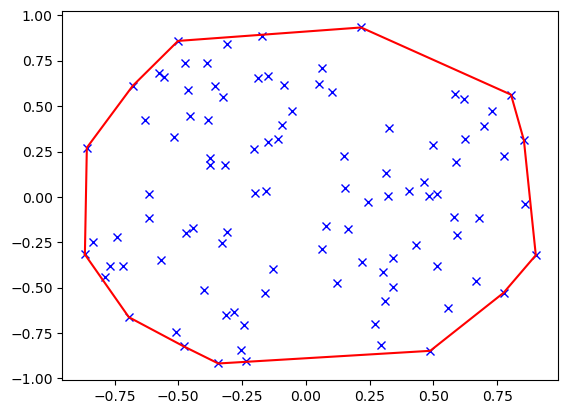

In [242]:
sweeping_test(100)